**1. Initialize Spark and load the data**

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .config("spark.driver.memory", "8g") \
    .appName("TelcoChurnPipeline") \
    .getOrCreate()

# adjust path as needed
data_path = "/mnt/data/WA_Fn-UseC_-Telco-Customer-Churn.csv"

df = spark.read.csv("Data/WA_Fn-UseC_-Telco-Customer-Churn.csv", header=True, inferSchema=True)
df = df.drop("customerID")   # drop unique ID
df.printSchema()
df.show(5)


root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)

+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+-

**2. Exploratory Data Analysis (EDA)**

In [2]:
# a) Basic stats for numerical columns
numeric_cols = [c for c,d in df.dtypes if d in ("int","double")]
df.select(numeric_cols).describe().show()

# b) Count missing values
from pyspark.sql.functions import col, sum
missing = df.select([ sum(col(c).isNull().cast("int")).alias(c) for c in df.columns ])
missing.show()

# c) Class balance
df.groupBy("Churn").count().show()


+-------+------------------+------------------+------------------+
|summary|     SeniorCitizen|            tenure|    MonthlyCharges|
+-------+------------------+------------------+------------------+
|  count|              7043|              7043|              7043|
|   mean|0.1621468124378816| 32.37114865824223| 64.76169246059922|
| stddev|0.3686116056100135|24.559481023094442|30.090047097678482|
|    min|                 0|                 0|             18.25|
|    max|                 1|                72|            118.75|
+-------+------------------+------------------+------------------+

+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSuppo

**3. Handle missing values & outliers**

In [3]:
# Example: drop rows with any nulls (or use df.na.fill() to impute)
df_clean = df.na.drop()

# Outlier detection example on MonthlyCharges
quantiles = df_clean.approxQuantile("MonthlyCharges", [0.25, 0.75], 0.0)
q1, q3 = quantiles
iqr = q3 - q1
lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr

df_no_outliers = df_clean.filter((col("MonthlyCharges") >= lower) & (col("MonthlyCharges") <= upper))


**4. Encode categoricals, assemble & scale**

In [10]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

# label
label_indexer = StringIndexer(inputCol="Churn", outputCol="label")

# categorical columns
cat_cols = [c for c,d in df_no_outliers.dtypes if d=="string" and c!="Churn"]
indexers = [ StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid="keep") for c in cat_cols ]
encoders = [ OneHotEncoder(inputCol=c+"_idx", outputCol=c+"_ohe") for c in cat_cols ]

# features list
num_cols = [c for c in numeric_cols]
assembled_inputs = num_cols + [c+"_ohe" for c in cat_cols]

assembler = VectorAssembler(inputCols=assembled_inputs, outputCol="features_assembled")
scaler = StandardScaler(inputCol="features_assembled", outputCol="features")


**5. PCA & scree plot**

In [11]:
from pyspark.ml import Pipeline

# 1) Build a mini‑pipeline of just your indexers, encoders, and assembler
feature_stages = indexers + encoders + [assembler]
feature_pipeline = Pipeline(stages=feature_stages)

# 2) Fit that pipeline on your cleaned data
feature_model = feature_pipeline.fit(df_no_outliers)

# 3) Transform to get the assembled features
assembled_df = feature_model.transform(df_no_outliers)

# Sanity check: you should now see "features_assembled" in the schema
assembled_df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)
 |-- gender_idx: double (nullable = false)
 |-- Partner_idx: double (nullable = false)
 |-- Dependents_idx: double (nullable

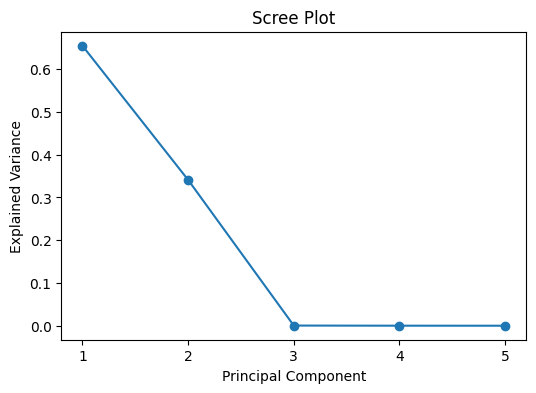

In [12]:

from pyspark.ml.feature import PCA

# 4) (Optional) If you want PCA on *scaled* inputs, first fit+transform the scaler:
# scaler_model = scaler.fit(assembled_df)
# assembled_df = scaler_model.transform(assembled_df)

# 5) Fit PCA
pca = PCA(k=5,
          inputCol="features_assembled",
          outputCol="pca_features")
pca_model = pca.fit(assembled_df)

# 6) Extract explained variance & plot scree
explained = pca_model.explainedVariance.toArray().tolist()

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(range(1, len(explained)+1), explained, marker='o')
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.xticks(range(1, len(explained)+1))
plt.show()



**6. Train-test split**

In [13]:
train_df, test_df = df_no_outliers.randomSplit([0.8, 0.2], seed=42)


**7. Build pipeline with classifier & hyperparameter tuning**

In [14]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# choose classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="label")

# full pipeline
stages = indexers + encoders + [label_indexer, assembler, scaler, rf]
pipeline = Pipeline(stages=stages)

# grid search
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [50,100])
             .addGrid(rf.maxDepth, [5,10])
             .build())

evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction")

cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5)

cvModel = cv.fit(train_df)
bestModel = cvModel.bestModel


**8. Evaluate on test set**

In [15]:
predictions = bestModel.transform(test_df)

# Overall metrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

acc_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
prec_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
rec_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

print(f"Accuracy:  {acc_evaluator.evaluate(predictions):.4f}")
print(f"Precision: {prec_evaluator.evaluate(predictions):.4f}")
print(f"Recall:    {rec_evaluator.evaluate(predictions):.4f}")
print(f"F1-score:  {f1_evaluator.evaluate(predictions):.4f}")

# AUC
auc = evaluator.setMetricName("areaUnderROC").evaluate(predictions)
print(f"AUC ROC:   {auc:.4f}")

# Confusion matrix
predictions.groupBy("label","prediction").count().orderBy("label","prediction").show()


Accuracy:  0.7368
Precision: 0.7685
Recall:    0.7368
F1-score:  0.6302
AUC ROC:   0.8306
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|  985|
|  0.0|       1.0|    1|
|  1.0|       0.0|  353|
|  1.0|       1.0|    6|
+-----+----------+-----+



In [21]:
predictions.printSchema()

root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)
 |-- gender_idx: double (nullable = false)
 |-- Partner_idx: double (nullable = false)
 |-- Dependents_idx: double (nullable

**9. Plot ROC curve**

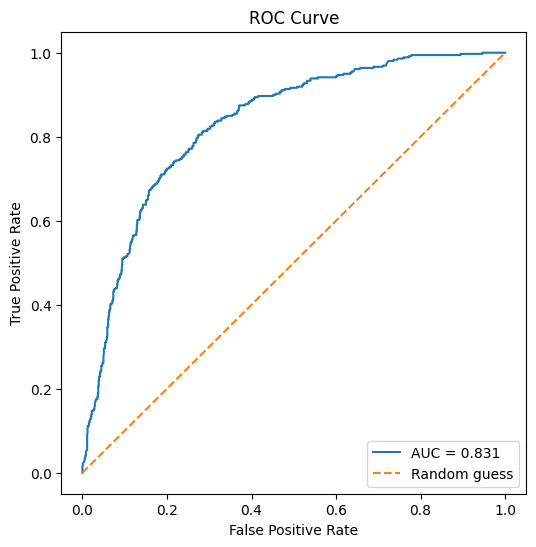

In [25]:
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col

# 1) Extract positive‐class probability via vector_to_array
prob_label_df = predictions.select(
    vector_to_array("probability").getItem(1).alias("prob"),
    col("label").alias("true")
)

# 2) Convert to Pandas
pdf = prob_label_df.toPandas()

# 3) Compute & plot ROC with scikit‐learn
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(pdf["true"], pdf["prob"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],"--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()
